# Mercari Price Prediction

Mercari is Japan's biggest community powered shopping app where people can sell and buy a variety of brand new and used products of different brands, from sweaters to smartphones. Now Mercari would like to suggest the correct prices to the sellers but this is tough because their sellers are enabled to put just about anything, or any bundle of things on Mercari's marketplace.
So our objective is to build a model that automatically suggests the right product prices to the sellers. We are provided of the following information for each product:

train_id - the id of the product

name - the title of the product

item_condition_id - the condition of the product provided by the sellers

category_name - category of the product

brand_name - the product's brand name

shipping - 1 if shipping fee is paid by seller and 0 if shipping fee is paid by buyer

item_description - the full description of the product

price - the price that the product was sold for (This is the target variable that we will predict)

This type of problem lies under the category of Supervised Regression Machine Learning:
Supervised: We have access to both the features and the target and our goal is to train a model that can learn a mapping between the two.
Regression: The target variable, price, is a continuous variable.

In [0]:
#for connecting to google drive
!pip install -U -q PyDrive              

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#for accessing the data file through the google drive shareable link
train=drive.CreateFile({'id':'1mN96UKMA2lcYq7vd5_MAPG9ybttjzIIM'})
train.GetContentFile('train.tsv')

# **Exploratory Data Analysis**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('train.tsv', sep='\t')
train, test = train_test_split(data, test_size=0.2, shuffle=False)
print(train.shape, test.shape)

(1186028, 8) (296507, 8)


In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [0]:
missing_values_table(data)

Your selected dataframe has 8 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
brand_name,632682,42.7
category_name,6327,0.4
item_description,4,0.0


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1186028 entries, 0 to 1186027
Data columns (total 8 columns):
train_id             1186028 non-null int64
name                 1186028 non-null object
item_condition_id    1186028 non-null int64
category_name        1180953 non-null object
brand_name           679756 non-null object
price                1186028 non-null float64
shipping             1186028 non-null int64
item_description     1186026 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 81.4+ MB


# **Exploratory Data Analysis**
There are a total of 8 features in this data set. The title and description of the features are follows:-

In [0]:
print('There are a total of',train.shape[0],'observations in the train data.')

There are a total of 1186028 observations in the train data.


In [0]:
train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description,price
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,1,No description yet,10.0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,52.0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,10.0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,1,New with tags. Leather horses. Retail for [rm]...,35.0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,0,Complete with certificate of authenticity,44.0


<h2> Price </h2>

In [0]:
train['price'].describe()

count    1.186028e+06
mean     2.672386e+01
std      3.844205e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

In [0]:
price = train['price'].values
price = np.sort(price, axis=None)
print('{}th percentile value is {}'.format(90, price[int(len(price)*(float(90)/100))]))

90th percentile value is 51.0


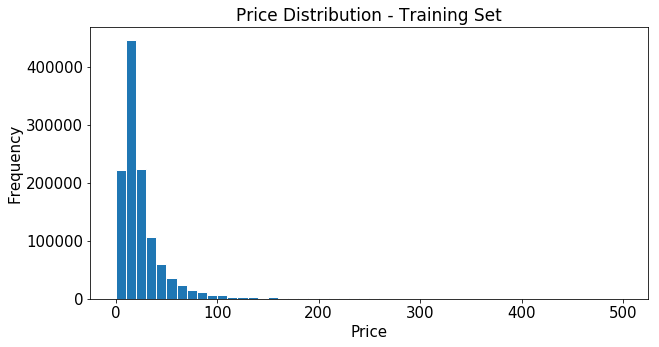

In [0]:
train['price'].plot.hist(bins=50, figsize=(10,5), edgecolor='white',range=[0,500])
plt.xlabel('Price', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)
plt.show()


Based on the the above statistics, the observations are as follows: 

*   The **median price** of the items is **17 dollars**.
*   Around **90% of the items** have price around **51 dollars or below**.
*   The **Price distribution** of the items is heavily **skewed to the right**.

<h2> Shipping </h2>

In [0]:
train['shipping'].value_counts(normalize=True)*100

0    55.267667
1    44.732333
Name: shipping, dtype: float64

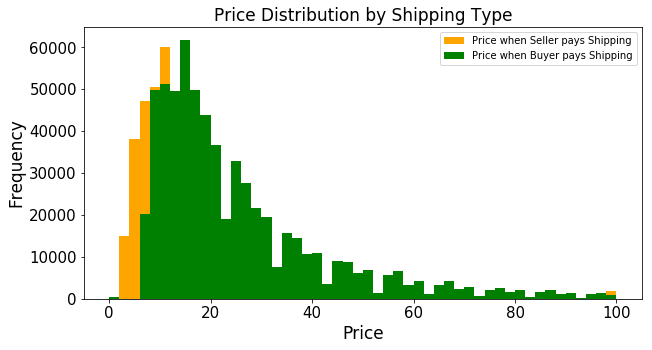

In [0]:
shipping_fee_by_seller = train.loc[train.shipping==1, 'price']
shipping_fee_by_buyer = train.loc[train.shipping==0, 'price']

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(shipping_fee_by_seller, color='Orange', alpha=1.0, bins=50, range=[0,100], label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='Green', alpha=1.0, bins=50, range=[0,100], label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('Price', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

In [0]:
print('The median price is ${}'.format(round(shipping_fee_by_seller.median(), 2)), 'if seller pays shipping')
print('The median price is ${}'.format(round(shipping_fee_by_buyer.median(), 2)), 'if buyer pays shipping')

The median price is $14.0 if seller pays shipping
The median price is $20.0 if buyer pays shipping


Some observations are as follows:-

*   The **shipping fee for 55%** of the **items** are **paid** by the **buyers.**
*   Normally when **we buy products online**, we **need to pay for shipping** or delivery for products which are **below a certain price.** But **here the trend is kind of opposite** since the median price of items for which the seller pays the shipping fees is lower than the median price of the items for which the buyer pays the shipping fees.   



<h2> Item Condition </h2>

The 'item_condition_id' has five unique values ranging from 1 to 5. Lower the number, better the condition of the item.

In [0]:
train['item_condition_id'].value_counts(normalize=True, sort=False)*100

1    43.194511
2    25.323264
3    29.166934
4     2.153153
5     0.162138
Name: item_condition_id, dtype: float64

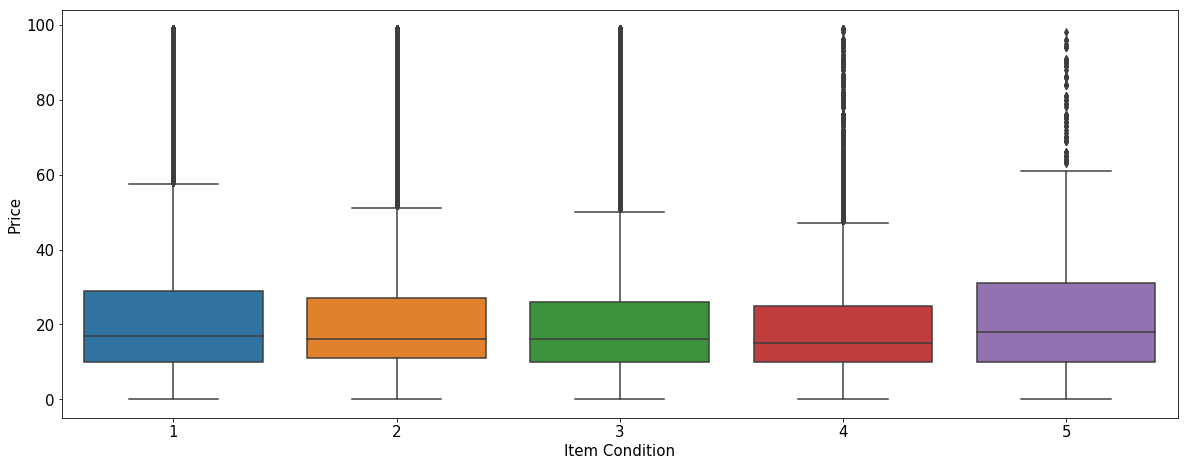

In [0]:
price_100 = train[train['price']<100]

fig, ax = plt.subplots(figsize=(20,7.5))
sns.boxplot(x='item_condition_id', y='price', data=price_100, ax=ax)
plt.xlabel('Item Condition', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Some observations are as follows:

*   **43% of the items** have item **condition ID as 1** while only **0.16% of the items** have item **condition ID has 5.**
*   Interestingly, items with item **condition ID as 5** have **higher median price** when compared with items having better condition. 



In [0]:
con = train[(train['item_condition_id']==5) & (train['price']>=20)]
con.head(6)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
653,653,Fossil vintage renewal purse,5,Women/Women's Handbags/Shoulder Bag,Fossil,36.0,0,No description yet
1027,1027,Broken necklace,5,Women/Jewelry/Necklaces,NaN,20.0,1,"10k gold 18"" chain. Broken at clasp."
2436,2436,Gameboy advance sp ags-101 FOR PARTS,5,Other/Other/Other,NaN,24.0,0,For parts . Turns on and hold battery charge ....
3177,3177,guitar,5,Other/Office supplies/Electronics,NaN,23.0,1,No description yet
3394,3394,iPod 1st generation 80gb,5,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,20.0,1,For parts or repair
5055,5055,Nintendo for parts,5,Electronics/Video Games & Consoles/Consoles,NaN,20.0,0,Powers on but won't play games.


<h2> Category Name </h2>

In [0]:
(train['category_name'].value_counts(normalize=True)*100).head(15)

Women/Athletic Apparel/Pants, Tights, Leggings                 4.060365
Women/Tops & Blouses/T-Shirts                                  3.134841
Beauty/Makeup/Face                                             2.321684
Beauty/Makeup/Lips                                             2.025398
Electronics/Video Games & Consoles/Games                       1.798039
Beauty/Makeup/Eyes                                             1.720390
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    1.675511
Women/Underwear/Bras                                           1.439346
Women/Tops & Blouses/Tank, Cami                                1.381511
Women/Tops & Blouses/Blouse                                    1.374314
Women/Dresses/Above Knee, Mini                                 1.356955
Women/Jewelry/Necklaces                                        1.348572
Women/Athletic Apparel/Shorts                                  1.328419
Beauty/Makeup/Makeup Palettes                                  1

As we can see, for each item, there are three sets of categories. The categories are arranged from top to bottom with respect to the comprehensiveness. Therefore we can split the categories into three different columns. The three categories will signify main category, first subcategory and second subcategory.

**As a common preprocessing practice, we will convert all the textual categorical values to lower case. The reason for doing this will be clear with the following example. Suppose there is an entry in the data and the product belonging to that entry is an iPhone 6s and the corresponding brand name belonging to that product is 'APPLE'. There is an another entry with the product iPhone 6s and the corresponding brand name given is 'Apple'. So when we featurise the data for applying the machine learning models, any featurisation technique that we will apply will consider 'APPLE' and 'Apple' has two different values eventhough they mean the same thing. So, for our model to consider these two values as one, we will convert all the textual categorical values to lower case. Effectively, 'APPLE' and 'Apple' will become 'apple' and 'apple'.**

Note:- These preprocessing steps will also be carried out on the test data, so that the train and test data both remained aligned with each other.

In [0]:
print("There are %d unique main categories." % train['category_name'].nunique())

There are 1268 unique main categories.


In [5]:
def split_cat(text):
    try: return text.split("/")
    except: return ("Category Unknown", "Category Unknown", "Category Unknown")
    
train['main_cat'], train['subcat_1'], train['subcat_2'] = zip(*train['category_name'].apply(lambda x: split_cat(x)))
test['main_cat'], test['subcat_1'], test['subcat_2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))
train.head()    

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [0]:
def lowercase_categorical_features_train(feature):
    original_list = list(train[feature].values)
    lower_case_list = []
    for i in original_list:
        j=i.lower()
        lower_case_list.append(j)
    return lower_case_list
  
def lowercase_categorical_features_test(feature):
    original_list = list(test[feature].values)
    lower_case_list = []
    for i in original_list:
        j=i.lower()
        lower_case_list.append(j)
    return lower_case_list  

In [0]:
train['subcat_1'] = lowercase_categorical_features_train('subcat_1')
train['subcat_2'] = lowercase_categorical_features_train('subcat_2')
train['main_cat'] = lowercase_categorical_features_train('main_cat')

test['subcat_1'] = lowercase_categorical_features_test('subcat_1')
test['subcat_2'] = lowercase_categorical_features_test('subcat_2')
test['main_cat'] = lowercase_categorical_features_test('main_cat')

In [8]:
print("There are %d unique main categories." % train['main_cat'].nunique())
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 11 unique main categories.
There are 114 unique first sub-categories.
There are 863 unique second sub-categories.


In [0]:
train['main_cat'].value_counts(normalize=True)*100

Women                     44.805350
Beauty                    14.035503
Kids                      11.561784
Electronics                8.265994
Men                        6.311740
Home                       4.595760
Vintage & Collectibles     3.138374
Other                      3.065189
Handmade                   2.083340
Sports & Outdoors          1.709066
Category Unknown           0.427899
Name: main_cat, dtype: float64

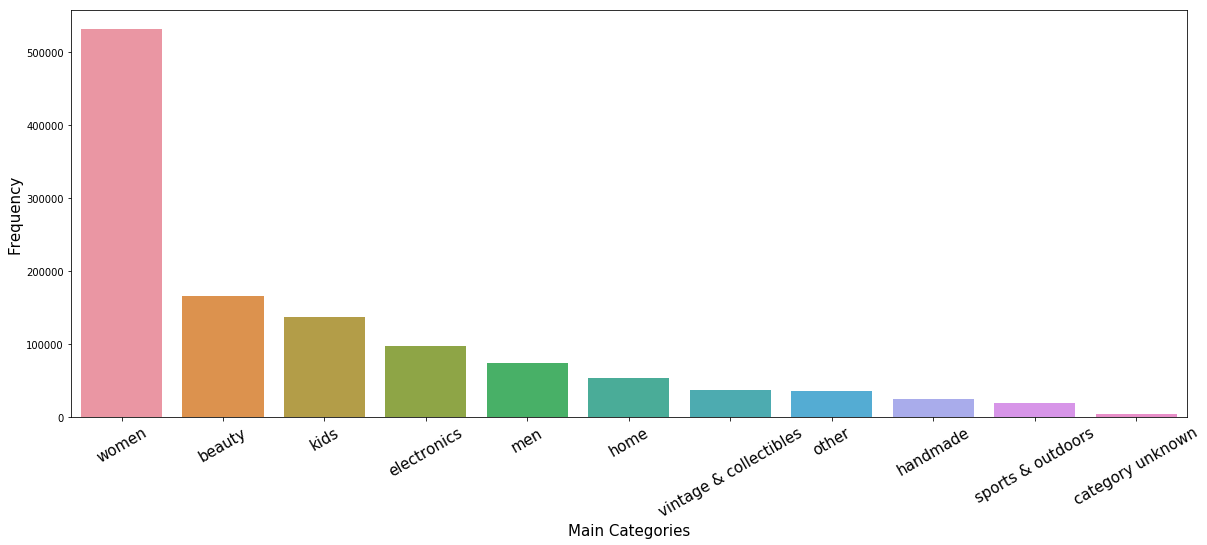

In [0]:
fig, ax = plt.subplots(figsize=(20,7.5))
sns.countplot(train['main_cat'], ax=ax, order=(train['main_cat'].value_counts()).index)
plt.xlabel('Main Categories', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(rotation=30, fontsize=15)
plt.show()

In [0]:
main_cat = train.groupby('main_cat')
main_cat_median = pd.DataFrame(main_cat['price'].median())
main_cat_median = main_cat_median.sort_values(ascending=True, by='price')
main_cat_median

,price
main_cat,
handmade,12.0
kids,14.0
other,14.0
beauty,15.0
electronics,15.0
category unknown,16.0
sports & outdoors,16.0
vintage & collectibles,16.0
home,18.0


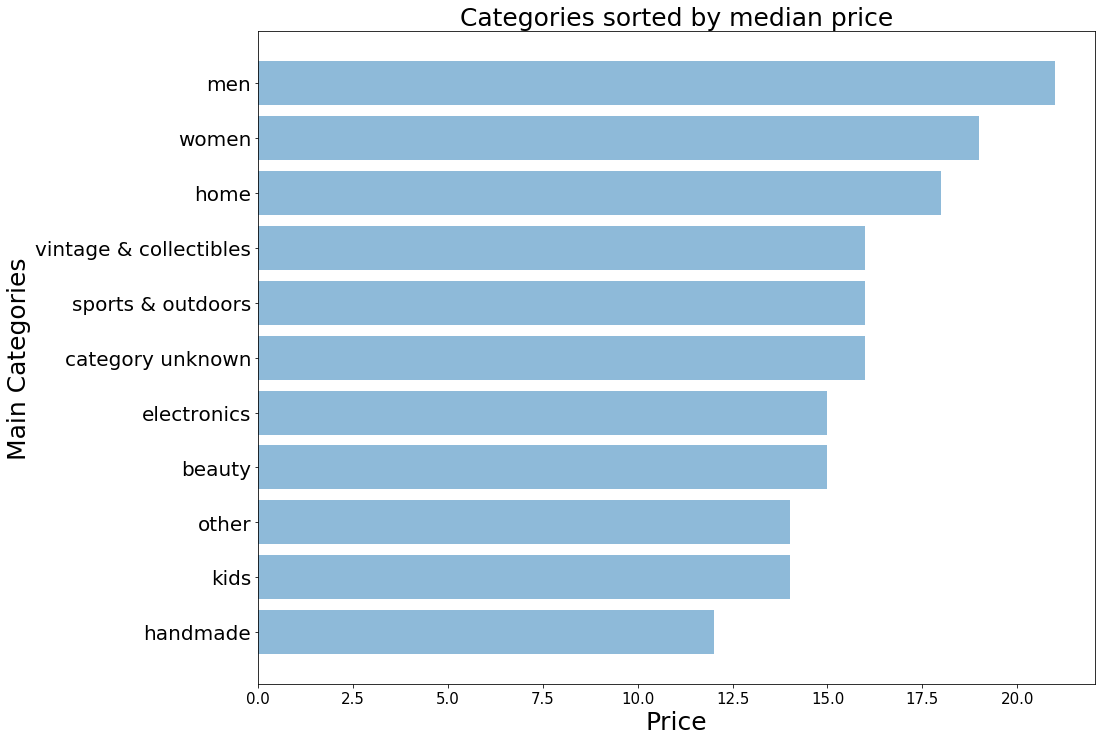

In [0]:
plt.figure(figsize=(15,12))
plt.barh(range(0,len(main_cat_median)), main_cat_median['price'], align='center', alpha=0.5)
plt.yticks(range(0,len(main_cat_median)), main_cat_median.index, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Categories sorted by median price', fontsize=25)
plt.xlabel('Price', fontsize=25)
plt.ylabel('Main Categories', fontsize=25)
plt.show()

**44.8% of the total products belong to 'Women' category followed by 'Beauty' category products which takes up around 14% of the total products while 1.7% of the products, being the minimum, belong to the 'Sports and Outdoor' category.**

**The items from 'Men' category have the highest median price of 21 dolars followed by the items from 'Women' category having a median price of 19 dollars while the items from 'Handmade' category has the lowest median price of 12 dollars.**

<h2> First Subcategory </h2>

In [0]:
train['subcat_1'].value_counts(normalize=True).head(10)

athletic apparel             0.090494
makeup                       0.084148
tops & blouses               0.072152
shoes                        0.067818
jewelry                      0.041684
toys                         0.039228
cell phones & accessories    0.035843
women's handbags             0.030885
dresses                      0.030855
women's accessories          0.028466
Name: subcat_1, dtype: float64

In [0]:
paper = train[train['subcat_1']=='paper goods']
paper.head(6)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_cat,subcat_1,subcat_2
442,442,Bundle for lexi,1,Handmade/Paper Goods/Sticker,NaN,7.0,1,these are handmade NEW AND IMPROVED STICKER MA...,handmade,paper goods,sticker
904,904,40 Thank you stickers,1,Handmade/Paper Goods/Sticker,NaN,3.0,1,20 smiley face 20 heart stickers You will rece...,handmade,paper goods,sticker
1127,1127,Ohio state deer antler decal,1,Handmade/Paper Goods/Sticker,NaN,7.0,0,Vinyl decal comes with high quality transfer t...,handmade,paper goods,sticker
1318,1318,10 Cricut Explore Pens,1,Handmade/Paper Goods/Scrapbooking,NaN,21.0,0,10 Cricut Pens- 2 packages! For Cricut Explore...,handmade,paper goods,scrapbooking
1329,1329,Tumblr Stickers: read description,1,Handmade/Paper Goods/Sticker,NaN,3.0,1,These are the stickers I have left besides the...,handmade,paper goods,sticker
1436,1436,Probably whiskey vinyl decal sticker,1,Handmade/Paper Goods/Sticker,NaN,9.0,0,"The size is 3"" leave me a message on a color. ...",handmade,paper goods,sticker


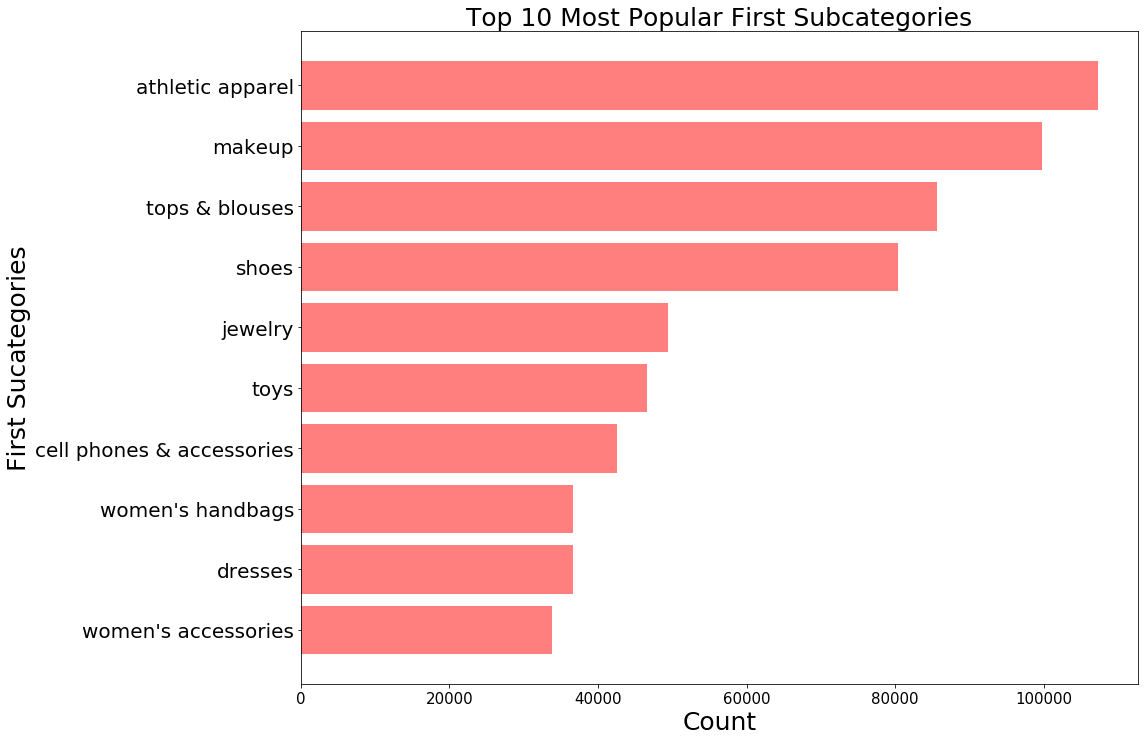

In [0]:
x = train['subcat_1'].value_counts().index[:10]
y = train['subcat_1'].value_counts().values[:10]

plt.figure(figsize=(15,12))
plt.barh(range(len(x),0,-1), y, align='center', alpha=0.5, color='red')
plt.yticks(range(len(x),0,-1), x, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Top 10 Most Popular First Subcategories', fontsize=25)
plt.xlabel('Count', fontsize=25)
plt.ylabel('First Sucategories', fontsize=25)
plt.show()

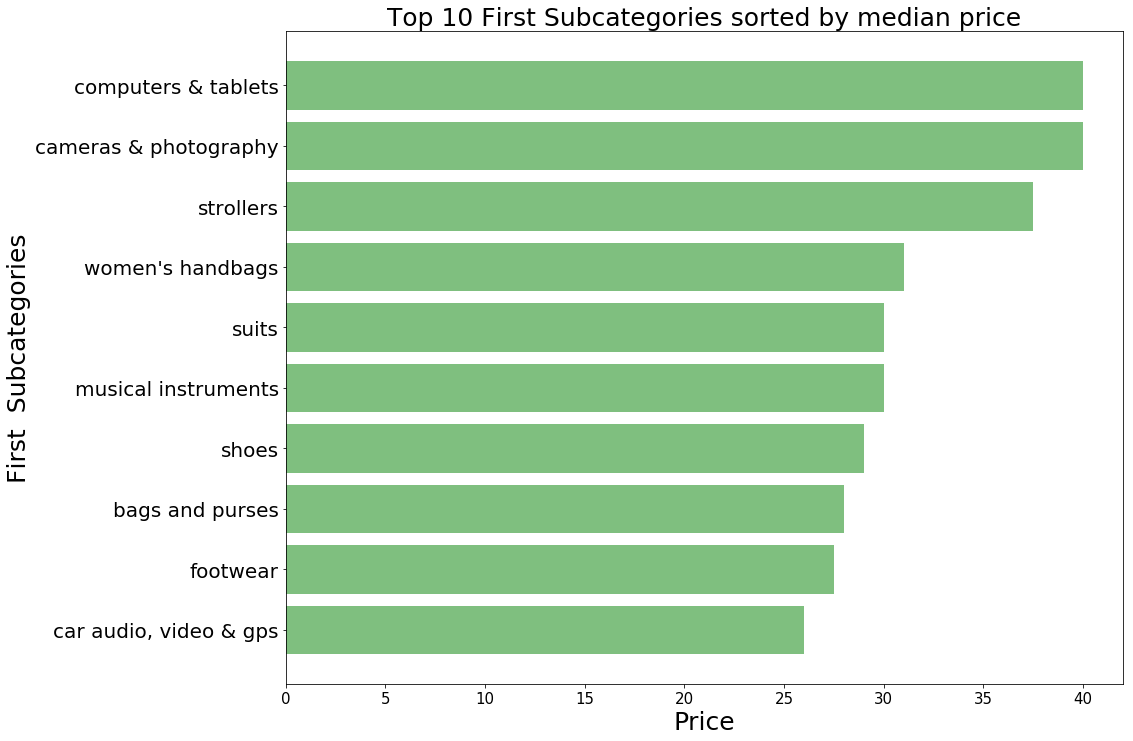

In [0]:
subcat_1 = train.groupby('subcat_1')
subcat_1_median = pd.DataFrame(subcat_1['price'].median())
subcat_1_median = subcat_1_median.sort_values(ascending=True, by='price')
subcat_1_median_top = subcat_1_median[-10:]
subcat_1_median_bottom = subcat_1_median[0:10]

plt.figure(figsize=(15,12))
plt.barh(range(0,len(subcat_1_median_top)), subcat_1_median_top['price'], align='center', alpha=0.5, color='green')
plt.yticks(range(0,len(subcat_1_median_top)), subcat_1_median_top.index, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Top 10 First Subcategories sorted by median price', fontsize=25)
plt.xlabel('Price', fontsize=25)
plt.ylabel('First  Subcategories', fontsize=25)
plt.show()

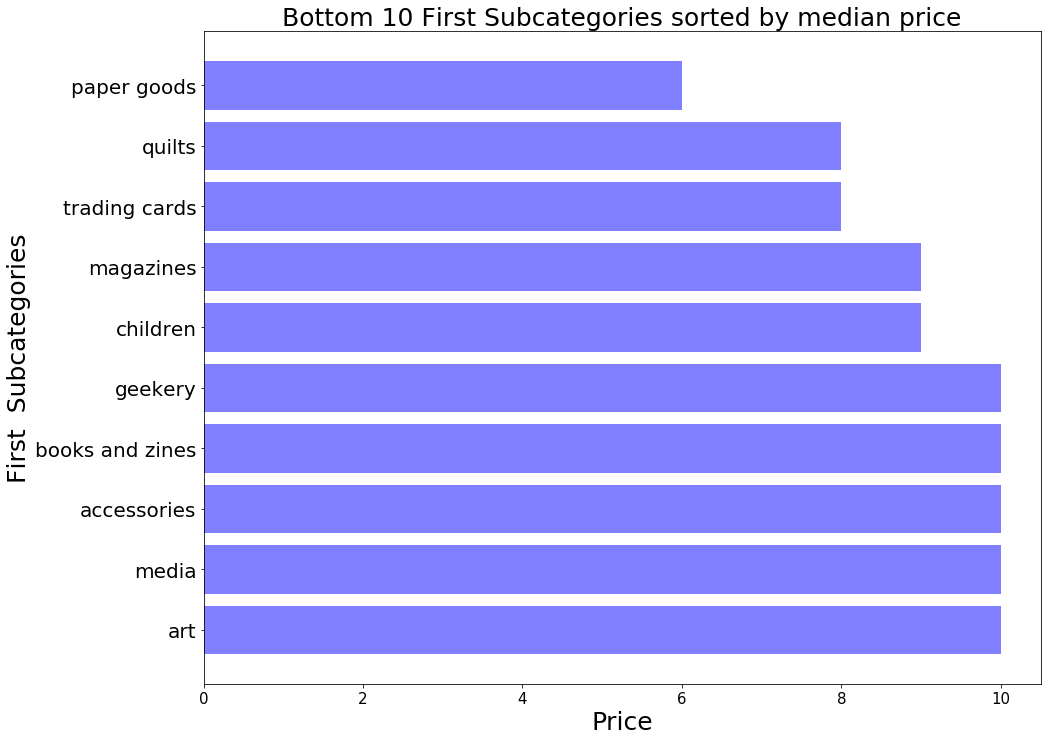

In [0]:
plt.figure(figsize=(15,12))
plt.barh(range(len(subcat_1_median_bottom),0,-1), subcat_1_median_bottom['price'], align='center', alpha=0.5, color='blue')
plt.yticks(range(len(subcat_1_median_bottom),0,-1), subcat_1_median_bottom.index, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Bottom 10 First Subcategories sorted by median price', fontsize=25)
plt.xlabel('Price', fontsize=25)
plt.ylabel('First  Subcategories', fontsize=25)
plt.show()

**The most popular subcategory is 'Athletic Apparel' which aligns with the previous observation that the most popular main category is 'Women' and 'Athletic Apparel' comes under both the 'Women' and 'Men' categories. 9% of the total products comes under the Athletic Apparel category.**

**From the perspective of the median price of the items, the items from the subcategory of 'Computers & Tablets' have the highest median price, with the median price being 40 dollars.**

**The items from the subcategory 'Paper Goods' have the lowest median price of 6 dollars. 'Paper Goods' come under the 'Handmade' category. This also validates the previous observation that the items from 'Handmade' category have the lowest median price out of all the main categories.**

In [0]:
stand = train[train['subcat_2']=='Standard']
stand

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_cat,subcat_1,subcat_2,clean_item_description
11730,11730,Minnie Mouse Stroller,3,Kids/Strollers/Standard,Disney,50.0,0,Good used condition The Minnie Mouse Fast Acti...,Kids,Strollers,Standard,good used condition minnie mouse fast action f...
73876,73876,Baby Jogger City Premiere,1,Kids/Strollers/Standard,Baby Jogger,275.0,0,Baby Jogger City Premiere stroller new in box ...,Kids,Strollers,Standard,baby jogger city premiere stroller new box col...
144452,144452,Mamas and Papas Sola,3,Kids/Strollers/Standard,Mamas & Papas,150.0,1,Very well taken care of stroller Has no flaws ...,Kids,Strollers,Standard,well taken care stroller flaws many years use ...
380115,380115,Bugaboo bee limited edition pendleton,2,Kids/Strollers/Standard,Bugaboo,76.0,0,Very hard to find Non extendable,Kids,Strollers,Standard,hard find non extendable
383116,383116,2015 uppababy vista,3,Kids/Strollers/Standard,UPPAbaby,480.0,1,"Good used condition, 2015 uppababy vista in si...",Kids,Strollers,Standard,good used condition 2015 uppababy vista silver...
427316,427316,Mama and papa Urbo 2 stroller,3,Kids/Strollers/Standard,Mamas & Papas,230.0,0,Mamas and papas stroller retails 599.00 plus tax,Kids,Strollers,Standard,mamas papas stroller retails 599 00 plus tax
446858,446858,Orbit Baby G3 Black Stroller Seat-NEW,1,Kids/Strollers/Standard,Orbit Baby,145.0,0,Seat only New in box,Kids,Strollers,Standard,seat new box
452110,452110,UppaBaby Jake Bassinet New Model,2,Kids/Strollers/Standard,UPPAbaby,70.0,1,Uppababy Jake Bassinet for strollers 2015 and ...,Kids,Strollers,Standard,uppababy jake bassinet strollers 2015 later ne...
769140,769140,G2 Orbit Baby Stroller Seat,2,Kids/Strollers/Standard,NaN,65.0,0,Used good condition,Kids,Strollers,Standard,used good condition
894690,894690,HOLD for LESLIE Nuna IVVI Stroller,3,Kids/Strollers/Standard,NaN,315.0,0,Very good condition. There's some crashes on t...,Kids,Strollers,Standard,good condition crashes handle stroller comes i...


<h2> Second Subcategory </h2>

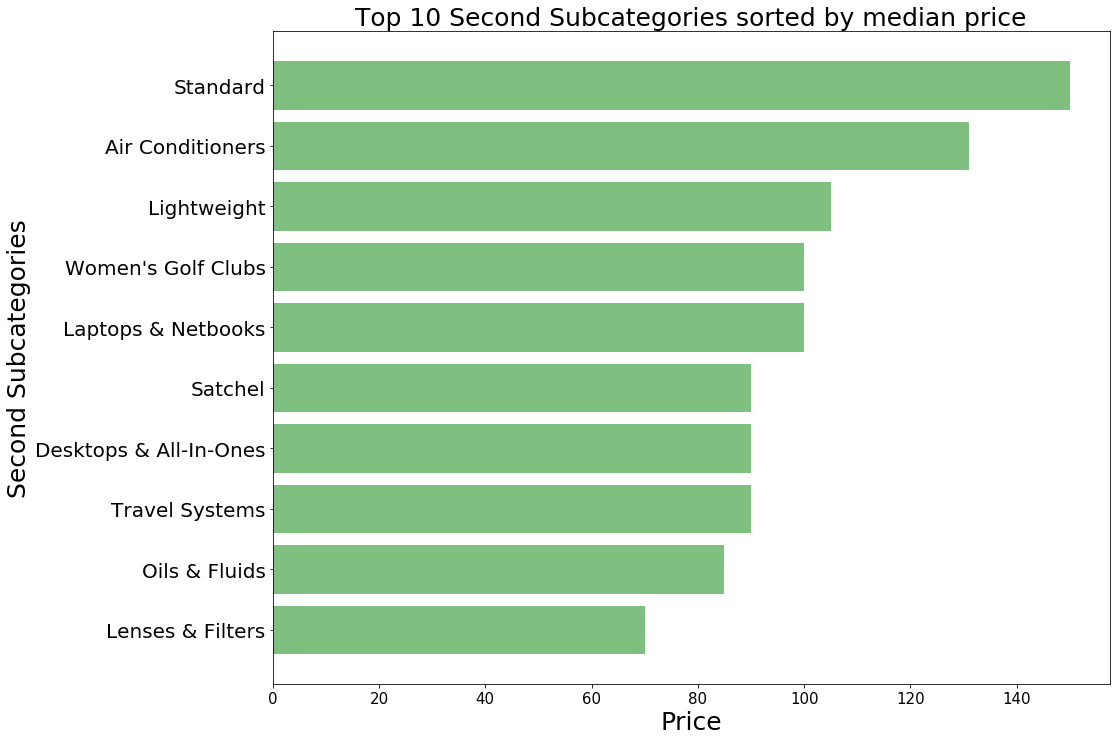

In [0]:
subcat_2 = train.groupby('subcat_2')
subcat_2_median = pd.DataFrame(subcat_2['price'].median())
subcat_2_median = subcat_2_median.sort_values(ascending=True, by='price')
subcat_2_median_top = subcat_2_median[-10:]
subcat_2_median_bottom = subcat_2_median[0:10]

plt.figure(figsize=(15,12))
plt.barh(range(0,len(subcat_2_median_top)), subcat_2_median_top['price'], align='center', alpha=0.5, color='green')
plt.yticks(range(0,len(subcat_2_median_top)), subcat_2_median_top.index, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Top 10 Second Subcategories sorted by median price', fontsize=25)
plt.xlabel('Price', fontsize=25)
plt.ylabel('Second Subcategories', fontsize=25)
plt.show()

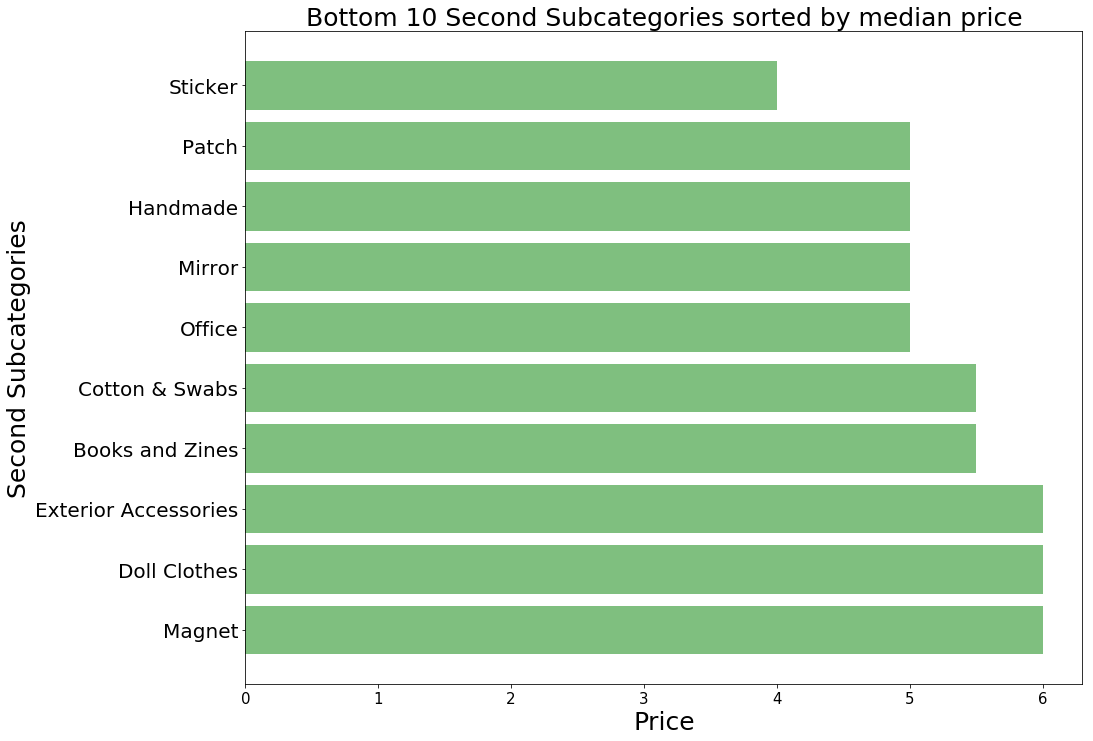

In [0]:
plt.figure(figsize=(15,12))
plt.barh(range(len(subcat_2_median_bottom),0,-1), subcat_2_median_bottom['price'], align='center', alpha=0.5, color='green')
plt.yticks(range(len(subcat_2_median_bottom),0,-1), subcat_2_median_bottom.index, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Bottom 10 Second Subcategories sorted by median price', fontsize=25)
plt.xlabel('Price', fontsize=25)
plt.ylabel('Second Subcategories', fontsize=25)
plt.show()

<h2> Brand </h2>

In [0]:
(train['brand_name'].value_counts(normalize=True)*100).head(10)

Nike                 6.368903
PINK                 6.358017
Victoria's Secret    5.679832
LuLaRoe              3.636158
Apple                2.032494
FOREVER 21           1.785641
Nintendo             1.781816
Lululemon            1.708848
Michael Kors         1.641766
American Eagle       1.571593
Name: brand_name, dtype: float64

In [0]:
print('There are', train['brand_name'].nunique(), 'unique brands in the data')

There are 4535 unique brands in the data


In [0]:
train['brand_name'] = train['brand_name'].fillna('brand_unavailable')
brand = list(train['brand_name'].values)
brand_name_given = []
for i in brand:
    if i=='brand_unavailable':
        brand_name_given.append('No')
    else:
        brand_name_given.append('Yes')
        
train['brand_name_given'] = brand_name_given   

test['brand_name'] = test['brand_name'].fillna('brand_unavailable')
brand = list(test['brand_name'].values)
brand_name_given = []
for i in brand:
    if i=='brand_unavailable':
        brand_name_given.append('No')
    else:
        brand_name_given.append('Yes')
        
test['brand_name_given'] = brand_name_given      

In [0]:
train['brand_name'] = lowercase_categorical_features_train('brand_name')
test['brand_name'] = lowercase_categorical_features_test('brand_name')

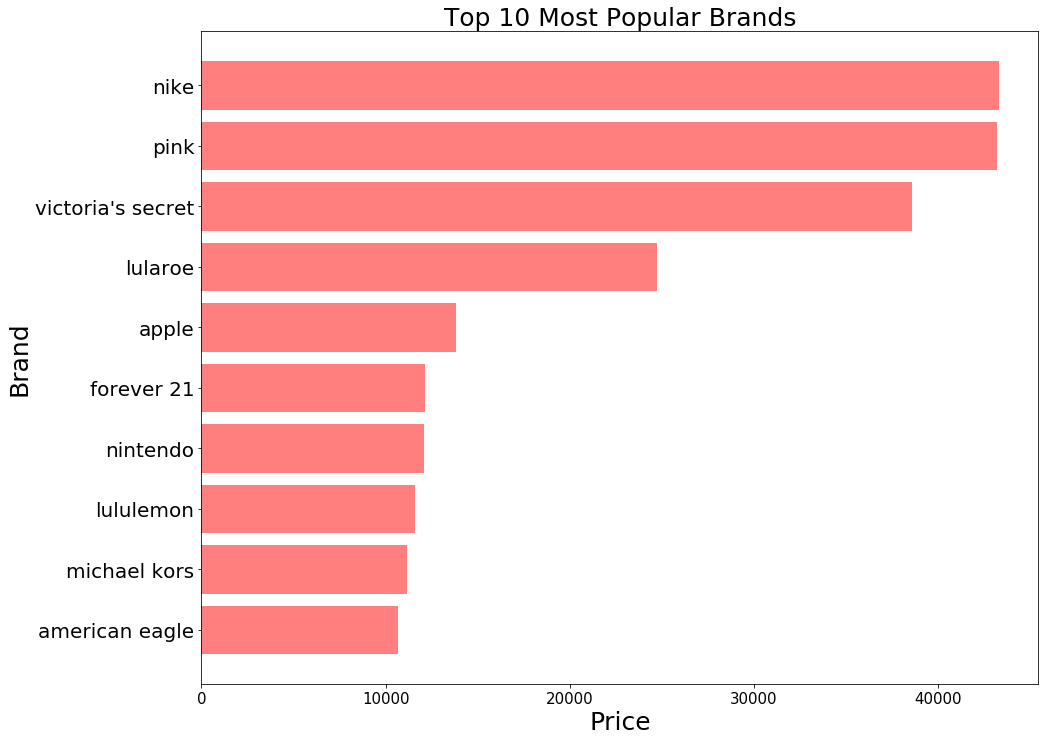

In [0]:
brand_filled = train[train['brand_name']!='brand_unavailable']

x = brand_filled['brand_name'].value_counts().index[:10]
y = brand_filled['brand_name'].value_counts().values[:10]

plt.figure(figsize=(15,12))
plt.barh(range(len(x),0,-1), y, align='center', alpha=0.5, color='red')
plt.yticks(range(len(x),0,-1), x, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Top 10 Most Popular Brands', fontsize=25)
plt.xlabel('Price', fontsize=25)
plt.ylabel('Brand', fontsize=25)
plt.show()

**Nike and Pink are the top two most popular brands and 12.6% of the total products in the data belong to these two brands.**

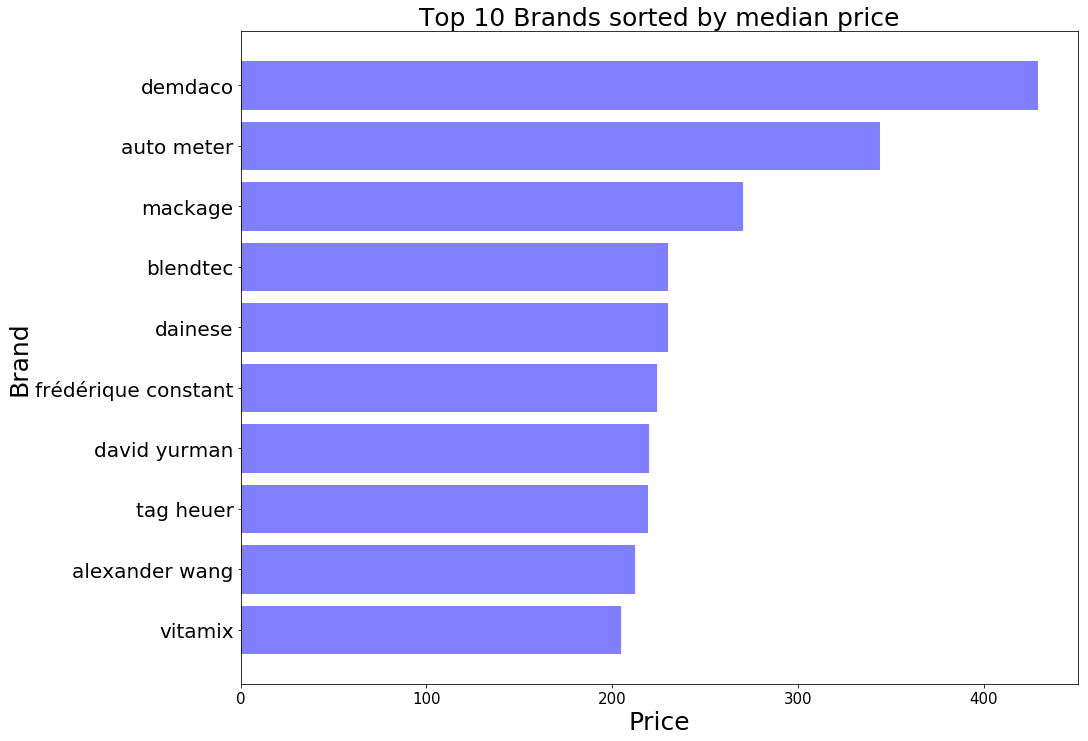

In [0]:
brand = train.groupby('brand_name')
brand_median = pd.DataFrame(brand['price'].median())
brand_median = brand_median.sort_values(ascending=True, by='price')
brand_median_top = brand_median[-10:]
brand_median_bottom = brand_median[0:10]

plt.figure(figsize=(15,12))
plt.barh(range(0,len(brand_median_top)), brand_median_top['price'], align='center', alpha=0.5, color='blue')
plt.yticks(range(0,len(brand_median_top)), brand_median_top.index, fontsize=20)
plt.xticks(fontsize=15)
plt.title('Top 10 Brands sorted by median price', fontsize=25)
plt.xlabel('Price', fontsize=25)
plt.ylabel('Brand', fontsize=25)
plt.show()

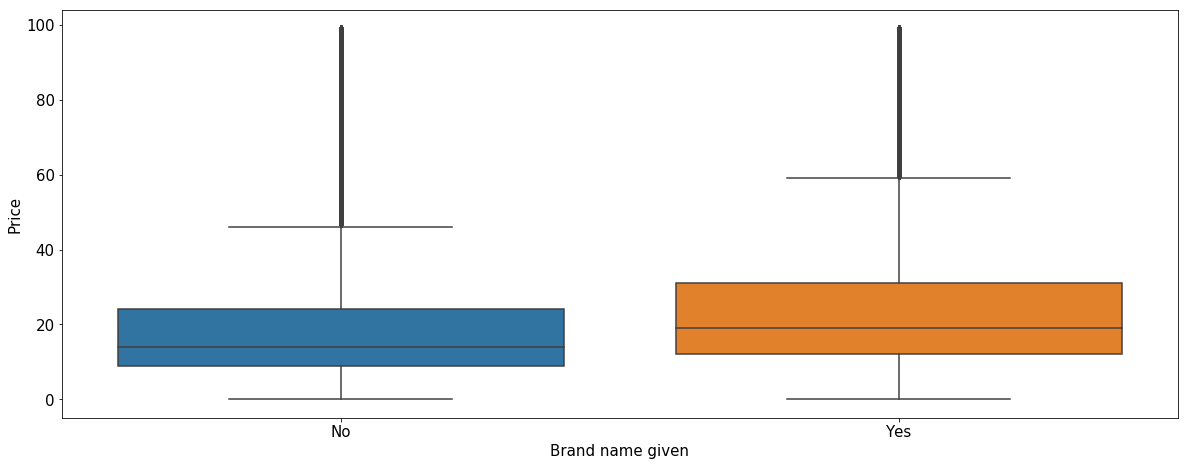

In [0]:
price_100 = train[train['price']<100]

fig, ax = plt.subplots(figsize=(20,7.5))
sns.boxplot(x='brand_name_given', y='price', data=price_100, ax=ax)
plt.xlabel('Brand name given', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [0]:
brand_given = train.groupby('brand_name_given')
brand_given_median = pd.DataFrame(brand_given['price'].describe())
brand_given_median

,count,mean,std,min,25%,50%,75%,max
brand_name_given,,,,,,,,
No,506272.0,21.108840,27.085329,0.0,9.0,14.0,24.0,1999.0
Yes,679756.0,30.905851,44.621451,0.0,12.0,20.0,34.0,2009.0


**After looking at the box plots, although there is good amount of overlap, we can say that there is a considerable difference in the prices when the brand is given and when it's not given. The median price of the product when the brand name is given is 20 dollars and when the brand name is not given, the median price is 14$. In a nutshell, this feature will be helpful for the ML model to map some kind of pattern from it.**

<h2> Item Description </h2>

In [10]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
from tqdm import tqdm
preprocessed_description = []
# tqdm is for printing the status bar
for description in tqdm(train['item_description'].values):
    sent = decontracted(str(description))
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_description.append(sent.lower().strip())
    
train['clean_description'] = preprocessed_description    

100%|██████████| 1186028/1186028 [01:22<00:00, 14315.83it/s]


In [13]:
from tqdm import tqdm
preprocessed_description = []
# tqdm is for printing the status bar
for description in tqdm(test['item_description'].values):
    sent = decontracted(str(description))
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_description.append(sent.lower().strip())
    
test['clean_description'] = preprocessed_description    

100%|██████████| 296507/296507 [00:20<00:00, 14186.60it/s]


In [0]:
no_desc = train[train['item_description']=='No description yet']
print((no_desc.shape[0]/train.shape[0])*100)

5.570273214460367


In [0]:
quantile = pd.qcut(train['price'], 4, labels=['first_q', 'second_q', 'third_q', 'fourth_q'])
price_q = list(quantile)
train['price_q'] = price_q

price_first_quantile = train[train['price_q']=='first_q']
price_second_quantile = train[train['price_q']=='second_q']
price_third_quantile = train[train['price_q']=='third_q']
price_fourth_quantile = train[train['price_q']=='fourth_q']

print(price_first_quantile.shape, price_second_quantile.shape, price_third_quantile.shape, price_fourth_quantile.shape)

(301057, 10) (303105, 10) (287683, 10) (294183, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


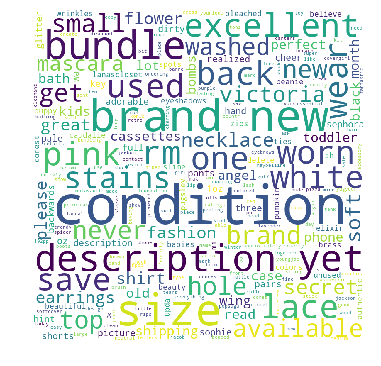

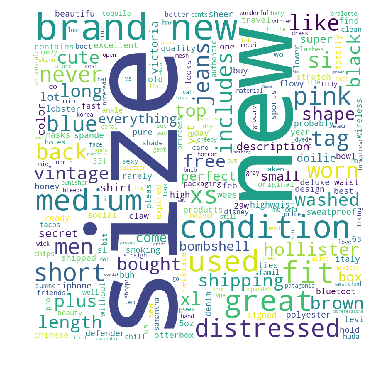

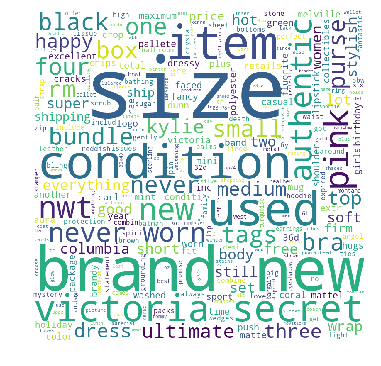

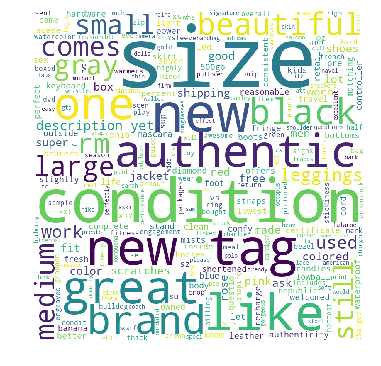

In [0]:
wordcloud_1 = WordCloud(width=800, height=800, background_color='white',stopwords=stopwords,max_words=300, min_font_size=10).generate(''.join(str(price_first_quantile['clean_description'])))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud_1)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

wordcloud_2 = WordCloud(width=800, height=800, background_color='white',stopwords=stopwords,max_words=300, min_font_size=10).generate(''.join(str(price_second_quantile['clean_description'])))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud_2)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

wordcloud_3 = WordCloud(width=800, height=800, background_color='white',stopwords=stopwords,max_words=300, min_font_size=10).generate(''.join(str(price_third_quantile['clean_description'])))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud_3)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

wordcloud_4 = WordCloud(width=800, height=800, background_color='white',stopwords=stopwords,max_words=300, min_font_size=10).generate(''.join(str(price_fourth_quantile['clean_description'])))
plt.figure(figsize=(5,5), facecolor=None)
plt.imshow(wordcloud_4)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [0]:
item_description = list(train['item_description'].values)
description_availability = []
for i in item_description:
    if i=='No description yet':
        description_availability.append('No')
    else:
        description_availability.append('Yes')
        
train['description_given'] = description_availability      

item_description = list(test['item_description'].values)
description_availability = []
for i in item_description:
    if i=='No description yet':
        description_availability.append('No')
    else:
        description_availability.append('Yes')
        
test['description_given'] = description_availability      

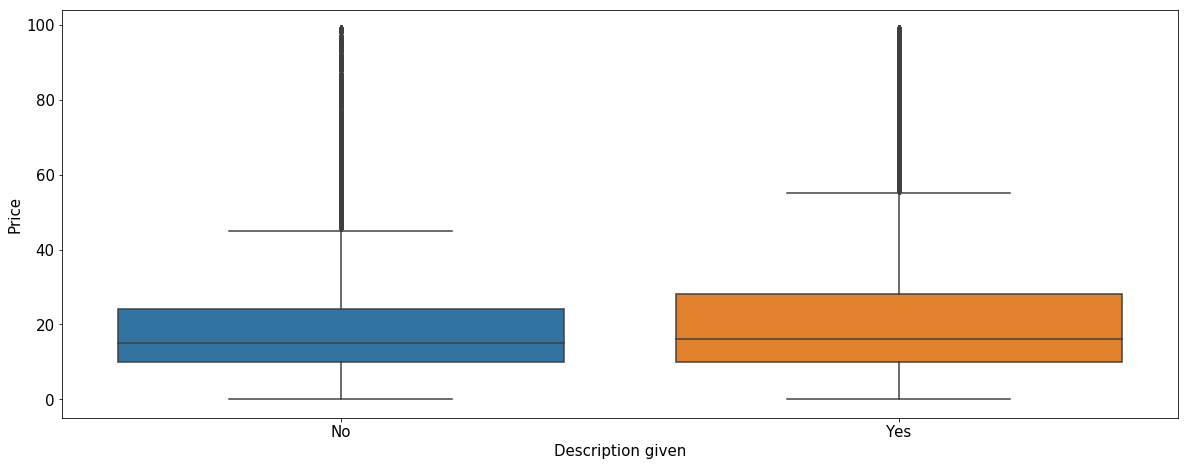

In [0]:
price_100 = train[train['price']<100]

fig, ax = plt.subplots(figsize=(20,7.5))
sns.boxplot(x='description_given', y='price', data=price_100, ax=ax)
plt.xlabel('Description given', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [0]:
desc_given = train.groupby('description_given')
desc_given_median = pd.DataFrame(desc_given['price'].describe())
desc_given_median

,count,mean,std,min,25%,50%,75%,max
description_given,,,,,,,,
No,66065.0,21.946409,29.950927,0.0,10.0,15.0,25.0,1506.0
Yes,1119963.0,27.005680,38.866737,0.0,10.0,17.0,30.0,2009.0


In [16]:
print(train.shape, test.shape)

(1186028, 14) (296507, 14)


In [0]:
#save the train and test data to pickle files to preserve the operations done till now and for further use during modelling
train.to_pickle('mercari_train')
test.to_pickle('mercari_test')

In [0]:
x_train, x_test = train.drop(['price'], axis=1), test.drop(['price'], axis=1)
y_train, y_test = train['price'], test['price']

<h2> Feature Engineering </h2>

In [15]:
from sklearn.preprocessing import OneHotEncoder

def onehot_encoding(feature):
    encoder = OneHotEncoder(handle_unknown='ignore')
    x_train_onehot = encoder.fit_transform(x_train[feature].values.reshape(-1,1))
    x_test_onehot = encoder.transform(x_test[feature].values.reshape(-1,1))
    return x_train_onehot, x_test_onehot
  
x_train_condition, x_test_condition = onehot_encoding('item_condition_id')
print(x_train_condition.shape, x_test_condition.shape)

(1186028, 5) (296507, 5)


In [1]:
x_train_brand, x_test_brand = onehot_encoding('brand_name')
x_train_brand_given, x_test_brand_given = onehot_encoding('brand_name_given')
x_train_condition, x_test_condition = onehot_encoding('item_condition_id')
x_train_shipping, x_test_shipping = onehot_encoding('shipping')
x_train_main_cat, x_test_main_cat = onehot_encoding('main_cat')
x_train_subcat_1, x_test_subcat_1 = onehot_encoding('subcat_1')
x_train_subcat_2, x_test_subcat_2 = onehot_encoding('subcat_2')

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(min_df=10, ngram_range=(1,2), binary=True)
x_train_bow_desc = bow.fit_transform(x_train['clean_description'])
x_test_bow_desc = bow.transform(x_test['clean_description'])

features_list.extend(bow.get_feature_names())
len(features_list)

270603

In [24]:
from scipy.sparse import hstack
x_train_final = hstack((x_train_brand, x_train_brand_given, x_train_condition, x_train_shipping, x_train_main_cat, x_train_subcat_1, x_train_subcat_2, x_train_bow_desc))
x_test_final = hstack((x_test_brand, x_test_brand_given, x_test_condition, x_test_shipping, x_test_main_cat, x_test_subcat_1, x_test_subcat_2, x_test_bow_desc))

print(x_train_final.shape, x_test_final.shape)

(1186028, 270603) (296507, 270603)


<h2> Evaluation Metric and Baseline Model </h2>

In [26]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

y_train_mean = y_train_log.mean() #for baseline prediction

from sklearn.metrics import mean_squared_error
def rmsle(y_test, y_pred):  
    return (np.sqrt(((y_test-y_pred)**2).mean())).round(4)
    return result
  
baseline_result = rmsle(y_test_log, y_train_mean)
baseline_result  

0.7497

In [0]:
y_train_log = np.log1p(y_train)

In [0]:
from sklearn.metrics import mean_squared_log_error
def get_rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

<h2> Implementing Machine Learning Models </h2>

<h3> Linear Regression </h3>

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor

LR = SGDRegressor(loss='squared_loss', random_state=42)
alpha = [10**i for i in range(-7,2)]
params = {'alpha':alpha}
RS_LR = RandomizedSearchCV(LR, params, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, random_state=42)
RS_LR.fit(x_train_final, y_train_log)
RS_LR.best_params_

{'alpha': 1e-07}

In [36]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_log_error
LR = SGDRegressor(loss='squared_loss', alpha=1e-07, random_state=42)
LR.fit(x_train_final, y_train_log)
y_pred_lr = LR.predict(x_test_final)

lr_error = rmsle(y_test_log, y_pred_lr)
lr_error

0.5168

<h3> Support Vector Regression </h3>

In [41]:
SVR = SGDRegressor(loss='epsilon_insensitive', random_state=42)
alpha = [10**i for i in range(-7,2)]
params = {'alpha':alpha}
RS_SVR = RandomizedSearchCV(SVR, params, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, random_state=42)
RS_SVR.fit(x_train_final, y_train_log)
RS_SVR.best_params_

{'alpha': 1e-06}

In [50]:
SVR = SGDRegressor(loss='epsilon_insensitive', alpha=1e-04, random_state=42)
SVR.fit(x_train_final, y_train_log)
y_pred_svr = SVR.predict(x_test_final)

svr_error = rmsle(y_test_log, y_pred_svr)
svr_error

0.5178

<h3> XGBoost Regression </h3>

In [34]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

XGB = xgb.XGBRegressor(random_state=42)
max_depth = [2,4,7,10]
n_estimators = [5,10,25,50,100]
params = {'n_estimators':n_estimators, 'max_depth':max_depth}
RS_XGB = RandomizedSearchCV(XGB, params, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, random_state=42)
RS_XGB.fit(x_train_final, y_train_log)
RS_XGB.best_params_

[10:19:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'max_depth': 10, 'n_estimators': 100}

In [35]:
XGB = xgb.XGBRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
XGB.fit(x_train_final, y_train_log)
y_test_pred_xgb = XGB.predict(x_test_final)

xgb_error = rmsle(y_test_log, y_test_pred_xgb)
xgb_error

[10:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.5975

<h3> Decision Tree Regression </h3>

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

DT = DecisionTreeRegressor(random_state=42)
min_samples_split = [25,50,75,100,200]
max_depth = [5,10,20,30,50]
params = {'max_depth':max_depth, 'min_samples_split':min_samples_split}
RS_DT = RandomizedSearchCV(DT, params, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, random_state=42)
RS_DT.fit(x_train_final, y_train_log)
RS_DT.best_params_

{'max_depth': 30, 'min_samples_split': 50}

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

DT = DecisionTreeRegressor(max_depth=30, min_samples_split=50, random_state=42)
DT.fit(x_train_final, y_train_log)
y_pred_dt = DT.predict(x_test_final)

dt_error = rmsle(y_test_log, y_pred_dt)
dt_error

0.582

<h2> Results Summary </h2>

In [52]:
from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ['Model', 'RMSLE']
pt.add_row(['Linear Regression', str(lr_error)])
pt.add_row(['Support Vector Regression', str(svr_error)])
pt.add_row(['Decision Tree Regression', str(dt_error)])
pt.add_row(['XGBoost Regression', str(xgb_error)])
print(pt)

+---------------------------+--------+
|           Model           | RMSLE  |
+---------------------------+--------+
|     Linear Regression     | 0.5168 |
| Support Vector Regression | 0.5178 |
|  Decision Tree Regression | 0.582  |
|     XGBoost Regression    | 0.5975 |
+---------------------------+--------+
